In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## **Import Data**

In [2]:
# Load data
df = pd.read_excel("coal.xlsx")
df

,Year,Coal Production,Coal Consumption
0,1973-01-01,49901.000,50578.608
1,1973-02-01,46461.000,45564.808
2,1973-03-01,51188.000,45402.955
3,1973-04-01,47580.000,43326.498
4,1973-05-01,52061.000,43999.759
...,...,...,...
619,2024-08-01,47110.135,42420.240
620,2024-09-01,45723.696,34504.966
621,2024-10-01,44295.355,30748.724
622,2024-11-01,40963.870,29732.855


In [3]:
scaler = StandardScaler()
data = scaler.fit_transform(df[['Coal Production']].values)

In [5]:
train_data, test_data  = train_test_split(data, test_size=0.1,shuffle = False)
train_data.shape, test_data.shape

((561, 1), (63, 1))

In [30]:
#dipake hasil errornya 1k an
sequence_length = 36
hidden_size = 256
num_layers = 2
dropout = 0.1
learning_rate = 0.0005
num_epochs = 300
batch_size = 32

In [31]:
class StockDataset(Dataset):
    def __init__(self, data, seq_len):
        self.x = []
        self.y = []
        for i in range(len(data) - seq_len):
            self.x.append(data[i:i+seq_len])
            self.y.append(data[i+seq_len])
        self.x = torch.tensor(np.array(self.x), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = StockDataset(data, sequence_length)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [32]:
train_dataset = StockDataset(train_data, sequence_length)
test_dataset = StockDataset(test_data, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## **Model LSTM**

In [33]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [34]:
model = LSTMModel()
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [35]:
for epoch in range(num_epochs):
    for x_batch, y_batch in loader:
        output = model(x_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")


Epoch [10/300], Loss: 0.112152
Epoch [20/300], Loss: 0.083776
Epoch [30/300], Loss: 0.065533
Epoch [40/300], Loss: 0.056308
Epoch [50/300], Loss: 0.054506
Epoch [60/300], Loss: 0.117618
Epoch [70/300], Loss: 0.096243
Epoch [80/300], Loss: 0.051524
Epoch [90/300], Loss: 0.040773
Epoch [100/300], Loss: 0.081227
Epoch [110/300], Loss: 0.080492
Epoch [120/300], Loss: 0.033325
Epoch [130/300], Loss: 0.029569
Epoch [140/300], Loss: 0.040549
Epoch [150/300], Loss: 0.020794
Epoch [160/300], Loss: 0.030369
Epoch [170/300], Loss: 0.025263
Epoch [180/300], Loss: 0.033016
Epoch [190/300], Loss: 0.021026
Epoch [200/300], Loss: 0.020632
Epoch [210/300], Loss: 0.019941
Epoch [220/300], Loss: 0.017255
Epoch [230/300], Loss: 0.016793
Epoch [240/300], Loss: 0.014344
Epoch [250/300], Loss: 0.023643
Epoch [260/300], Loss: 0.009306
Epoch [270/300], Loss: 0.006177
Epoch [280/300], Loss: 0.011490
Epoch [290/300], Loss: 0.006013
Epoch [300/300], Loss: 0.005446


In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    # Hindari pembagian dengan nol
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

def evaluate_model(model, data_loader, scaler):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            output = model(x_batch)

            y_true.extend(y_batch.view(-1).numpy())
            y_pred.extend(output.view(-1).numpy())

    # Inverse transform
    y_true = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return mae, rmse, mape, y_true, y_pred

mae_train, rmse_train, mape_train, y_train_true, y_train_pred = evaluate_model(model, train_loader, scaler)
mae_test, rmse_test, mape_test, y_test_true, y_test_pred = evaluate_model(model, test_loader, scaler)

print("\n📊 Evaluasi:")
print(f"Training -> MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")
print(f"Testing  -> MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")



📊 Evaluasi:
Training -> MAE: 854.77, RMSE: 1157.39, MAPE: 1.18%
Testing  -> MAE: 1289.03, RMSE: 1542.76, MAPE: 2.89%


## **Save Model**

In [14]:
# Save full model
torch.save(model.state_dict(), "lstm_model_batubara_baru.pth")
print("✅ Model berhasil disimpan")


✅ Model berhasil disimpan


In [139]:
torch.save(model, "full_lstm_model_batubara.pth")

## **Model Load**

In [ ]:
# Definisikan kembali arsitektur model yang sama persis
model = LSTMModel()
model.load_state_dict(torch.load("lstm_model_batubara_baru.pth"))
model.eval()  # Jangan lupa eval mode untuk inference


LSTMModel(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    # Hindari pembagian dengan nol
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

def evaluate_model(model, data_loader, scaler):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            output = model(x_batch)

            y_true.extend(y_batch.view(-1).numpy())
            y_pred.extend(output.view(-1).numpy())

    # Inverse transform
    y_true = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return mae, rmse, mape, y_true, y_pred

mae_train, rmse_train, mape_train, y_train_true, y_train_pred = evaluate_model(model, train_loader, scaler)
mae_test, rmse_test, mape_test, y_test_true, y_test_pred = evaluate_model(model, test_loader, scaler)

print("\n📊 Evaluasi:")
print(f"Training -> MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")
print(f"Testing  -> MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")



📊 Evaluasi:
Training -> MAE: 977.11, RMSE: 1319.87, MAPE: 1.34%
Testing  -> MAE: 1049.54, RMSE: 1227.93, MAPE: 2.39%


## **Visual**

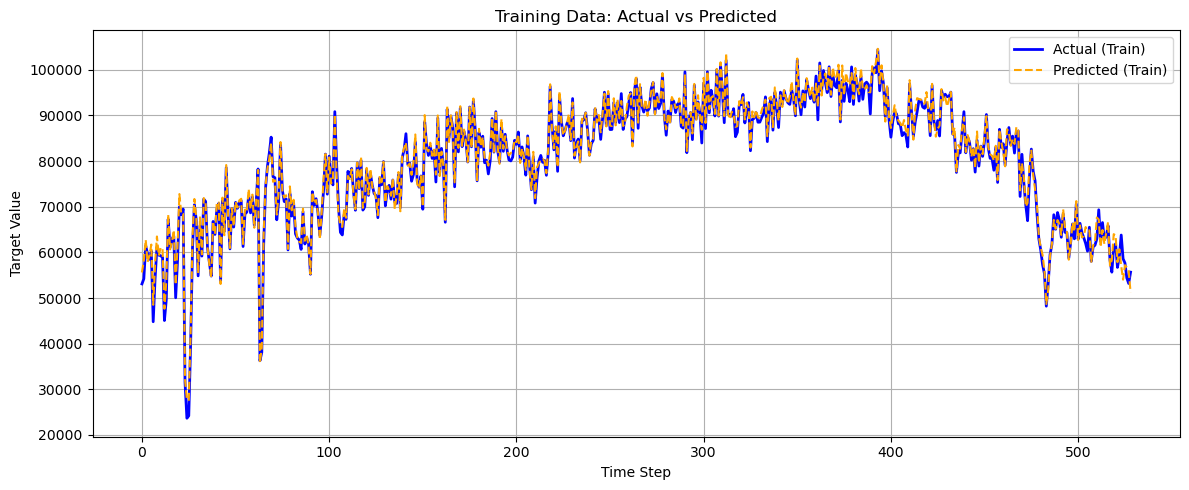

In [127]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 5))
plt.plot(y_train_true, label='Actual (Train)', color='blue', linewidth=2)
plt.plot(y_train_pred, label='Predicted (Train)', color='orange', linestyle='--')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


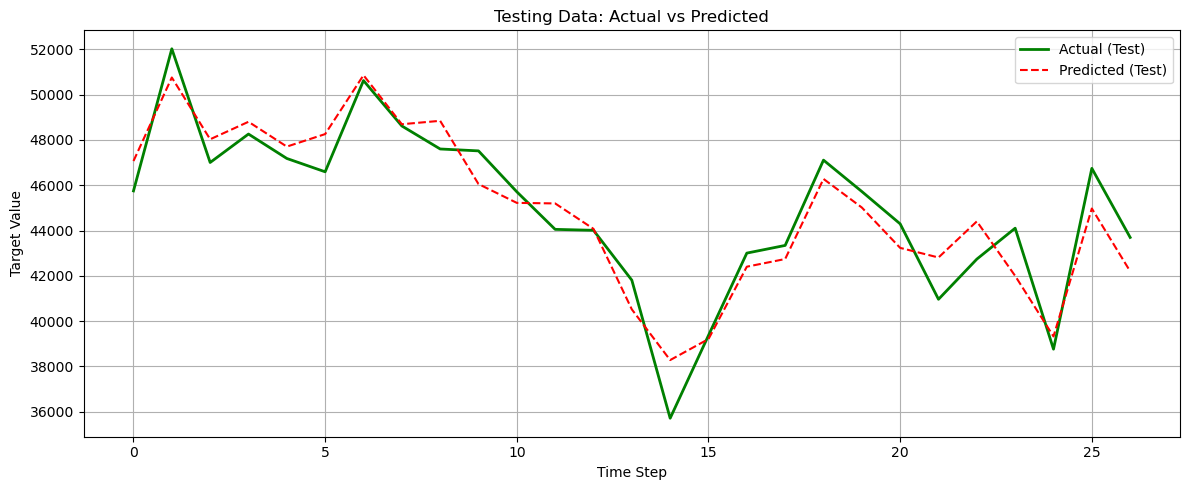

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_true, label='Actual (Test)', color='green', linewidth=2)
plt.plot(y_test_pred, label='Predicted (Test)', color='red', linestyle='--')
plt.title('Testing Data: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


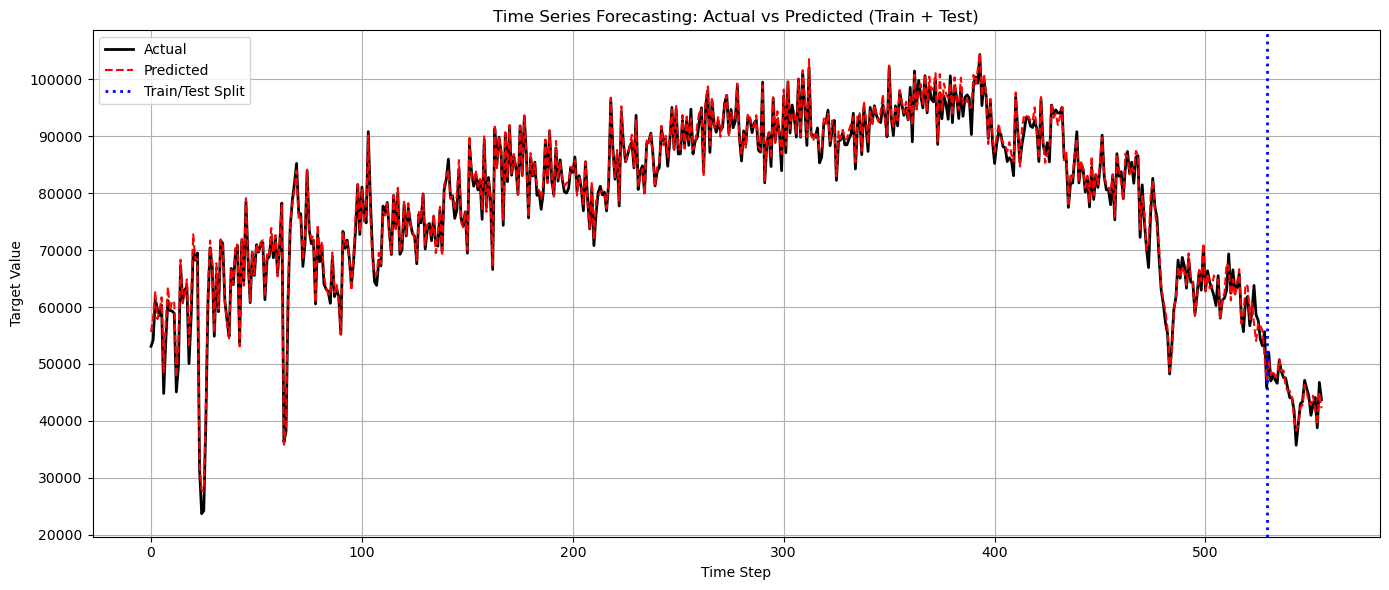

In [129]:
# Gabungkan hasil prediksi dan nilai aktual
y_all_true = np.concatenate([y_train_true, y_test_true])
y_all_pred = np.concatenate([y_train_pred, y_test_pred])

# Buat pembatas antara train dan test
split_index = len(y_train_pred)

plt.figure(figsize=(14, 6))

plt.plot(y_all_true, label='Actual', color='black', linewidth=2)
plt.plot(y_all_pred, label='Predicted', color='red', linestyle='--')

# Tambahkan garis vertikal untuk memisahkan train/test
plt.axvline(x=split_index, color='blue', linestyle=':', linewidth=2, label='Train/Test Split')

# Anotasi
plt.title('Time Series Forecasting: Actual vs Predicted (Train + Test)')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [135]:
def forecast_future(model, last_sequence, n_steps, scaler):
    """
    last_sequence : array shape (sequence_length, 1), sudah dinormalisasi
    n_steps       : jumlah langkah yang ingin diprediksi
    """
    model.eval()
    predictions = []

    current_seq = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0)  # (1, seq_len, 1)

    with torch.no_grad():
        for _ in range(n_steps):
            output = model(current_seq)
            next_value = output.item() 

            # Simpan prediksi (masih dalam skala normalisasi)
            predictions.append(next_value)

            # Update sequence: buang data pertama, tambahkan prediksi baru
            next_input = torch.tensor([[next_value]], dtype=torch.float32)  # shape (1, 1)
            current_seq = torch.cat((current_seq[:, 1:, :], next_input.unsqueeze(0)), dim=1)

    # Balik ke skala asli
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions).flatten()
    return predictions


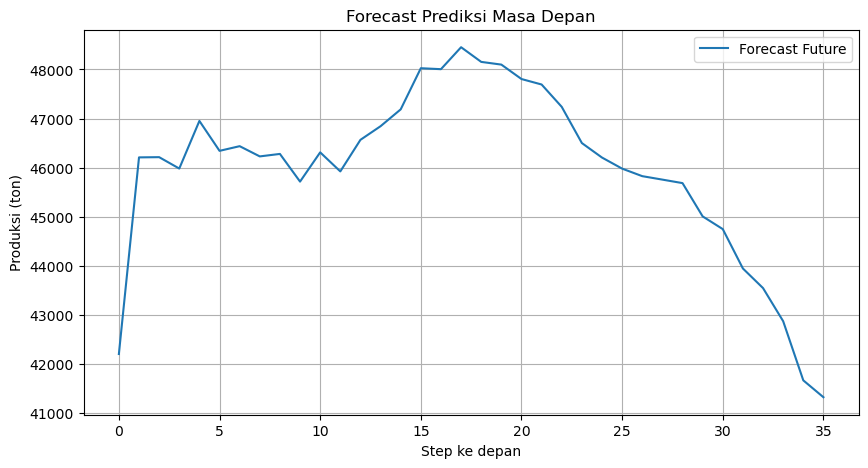

In [136]:
n_steps_ahead = 36  # misalnya prediksi 30 langkah ke depan

# Ambil window terakhir dari data test
last_sequence = test_dataset.x[-1].numpy()  # sudah berbentuk (sequence_length, 1)

# Prediksi ke depan
future_preds = forecast_future(model, last_sequence, n_steps=n_steps_ahead, scaler=scaler)

# Plot prediksi masa depan
plt.figure(figsize=(10,5))
plt.plot(range(n_steps_ahead), future_preds, label="Forecast Future")
plt.title("Forecast Prediksi Masa Depan")
plt.xlabel("Step ke depan")
plt.ylabel("Produksi (ton)")
plt.grid(True)
plt.legend()
plt.show()

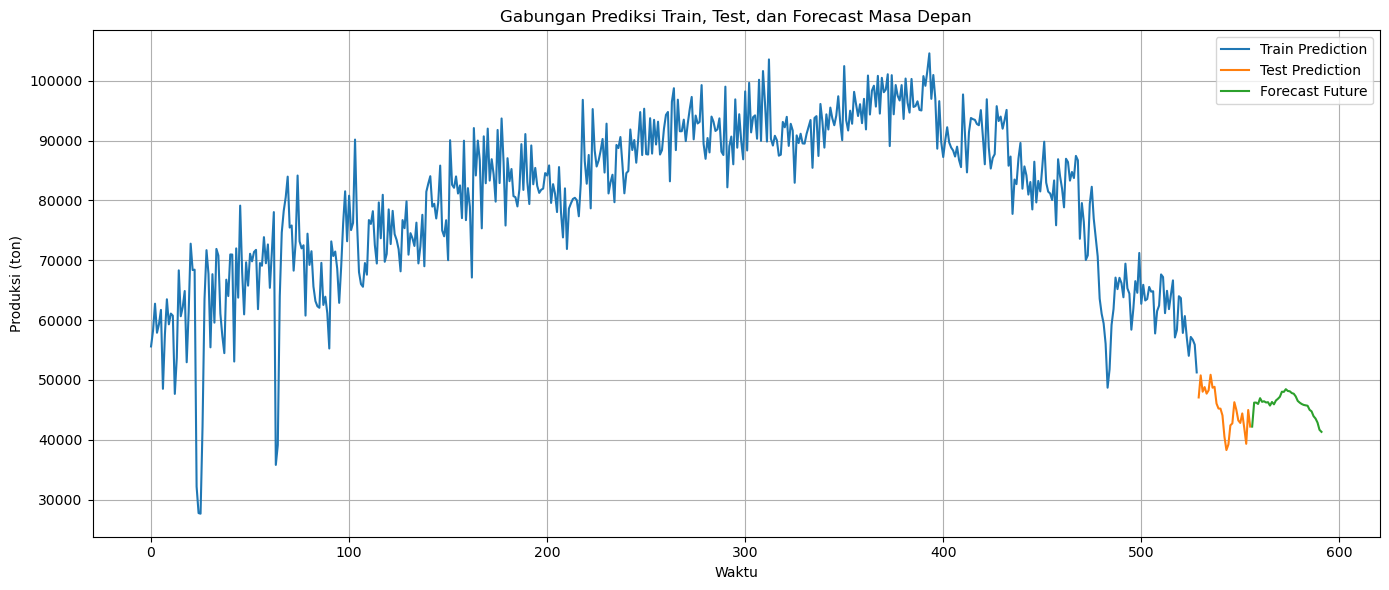

In [147]:
# Hitung panjang masing-masing bagian
len_train = len(y_train_pred)
len_test = len(y_test_pred)
len_forecast = len(future_preds)

# Buat indeks waktu gabungan
total_len = len_train + len_test + len_forecast
time_train = np.arange(len_train)
time_test = np.arange(len_train, len_train + len_test)
time_forecast = np.arange(len_train + len_test, total_len)

# Plot gabungan
plt.figure(figsize=(14,6))
plt.plot(time_train, y_train_pred, label='Train Prediction')
plt.plot(time_test, y_test_pred, label='Test Prediction')
plt.plot(time_forecast, future_preds, label='Forecast Future')

plt.title("Gabungan Prediksi Train, Test, dan Forecast Masa Depan")
plt.xlabel("Waktu")
plt.ylabel("Produksi (ton)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()